# Mesh construction for fractured domains in PorePy
This notebook presents various aspects related to construction of and modeling with the mixed-dimensional mesh in PorePy. Topics covered are
* Definition of fractures and fracture networks in 2d and 3d
* Mesh construction, including grid size tuning
* Mortar grids
* Construction of non-matching grids
* Projection operators between grids and interfaces

The notebook focus exclusively on unstructured grids, which are the preferred method for realistic fracture network. Note that it is also possible to generate mixed-dimensional grids with a Cartesian structure, with the obvious limitations on geometry etc. The Cartesian option can be valuable for debuging etc. For more information, see pp.meshing.structured.

In [1]:
# The standard imports
import numpy as np

import porepy as pp

c:\users\keile\dropbox\workspace\python\ppdir\src\porepy\grids\partition.py:19: UserWarning: Could not import pymetis. Some functions will not work as    intended
  intended"


# 2d geometry
Fractures in 2d are defined as straight lines, specified by the coordinates of their endpoints. Curved fractures are not permissible, although approximations by polylines are possible. 

The computational domain for 2d problems is defined as a set of fractures, together with a bounding box. The goto-place for such domains is the class FractureNetwork2d.

Non-rectangular, indeed non-convex, domains are possible, but not yet included in the fracture network class.


Below, we define a set of points and edges, defined to illustrate various properties of the FractureNetwork2d class.


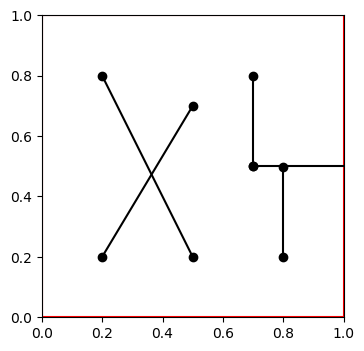

In [2]:
# Define a set of points, specified as a 2 x n_pt array (note transpose in the definition of p)
p = np.array([[0.2, 0.2],
              [0.5, 0.7],
              [0.2, 0.8],
              [0.5, 0.2],
              [0.7, 0.5],
              [1.5, 0.5],
              [0.7, 0.8],
              [0.8, 0.2],
              [0.8, 0.499]
             ]).T

# Fractures are defined by their start and endpoints, referring to the points in p
# The connections are specified by a 2 x num_frac array (again we use a transpose in the definition below)
fracs = np.array([[0, 1],
                  [2, 3],
                  [4, 5],
                  [4, 6],
                  [7, 8]
                 ]).T

# Finally, the domain is specified as a dictionary
domain = {'xmin': 0, 'xmax': 1, 'ymin': 0, 'ymax': 1}

network_2d = pp.FractureNetwork2d(p, fracs, domain)

# Plot the network, including its domain
network_2d.plot()


Comments on the above construction:
1. Point number 4 is shared between two fractures
2. Fracture number 2 extends outside the domain
3. Point number 8 is very close to fracture number 2, and will be demanding in terms of meshing.

The FractureNetwork2d class can deal with the two last issues. First, constrain the fractures so that they lie inside the domain:

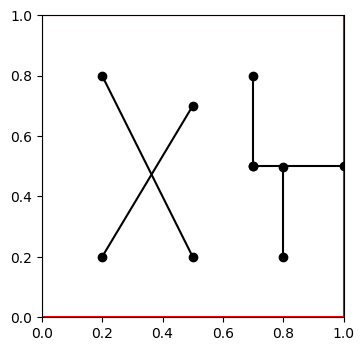

In [3]:
network_2d_modified = network_2d.constrain_to_domain()
network_2d_modified.plot()

Note that the constrained network has a point on the right boundary.

Next, snap the point that lies close to fracture 2, so that it lies on the line:

In [4]:
print(f'Before: {network_2d_modified.pts[:, -1]}')
network_2d_modified = network_2d_modified.snap(tol=2e-3)
print(f'After: {network_2d_modified.pts[:, -1]}')

Before: [0.8   0.499]
After: [0.8 0.5]


## Meshing
The next step is meshing. A mixed-dimensional grid, fit for computations, can be constructed using the function FractureNetwork2d.mesh(). The actual mesh is constructed by Gmsh; on the PorePy side, the meshing involves preprocessing of the geometry, attempts at mesh size control, and a fair amount of postprocessing to arrive at the PorePy mesh.

It is critical to set the mesh size parameter: This is controlled by three parameters: The target mesh size on the boundary and fractures, and the minimal 'acceptable' mesh size. The latter is somewhat misleading, as the conneciton between the parameter set, and the values returned by Gmsh is at best corrolated. 

For complex networks, the meshing process requires some experience, and sometimes manual tuning of the grid directly in Gmsh; as a general comment meshing of small details either requires many cells, or leads to bad grids.

C:\Users\keile\Anaconda3\lib\site-packages\mpl_toolkits\mplot3d\axes3d.py:753: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


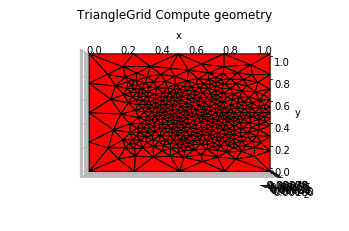

In [5]:
# Set a relatively coarse target mesh size on the boundary, attempt some refinement towards the fractures
target_h_bound = 0.3
target_h_fracture = 0.04

# The mesh size parameters must be packaged inside a dictionary
mesh_args = {'mesh_size_bound': target_h_bound, 'mesh_size_frac': target_h_fracture}

# Construct the mesh to obtain a mixed-dimensional PorePy mesh
gb_2d = network_2d_modified.mesh(mesh_args)

# Pick out the 2d grid for ploting
g_2d =gb_2d.grids_of_dimension(2)[0]

pp.plot_grid(g_2d)

If we try to use the original network, before snapping, for meshing, this will (may?) result in an error message which can be traced back to Gmsh issues related to too fine geometry details compared to the prescribed mesh size.

# The GridBucket
Next, let's have a look a the mixed-dimensional grid, represented by a GridBucket object. This is essentially a graph, the implementation is a wrapper around the NetworkX graph object, where the nodes are subdomains (fractures, fracture intersections, the host medium), while the graph edges are interfaces between subdomains. 

First, print some information on the GridBucket and one of its components

In [6]:
print(gb_2d)

# Pick out the mesh of the 2d subdomain
g_2d = gb_2d.grids_of_dimension(dim=2)[0]
print(g_2d)

Mixed dimensional grid. 
Maximum dimension 2
Minimum dimension 0
Size of highest dimensional grid: Cells: 772. Nodes: 454
In lower dimensions: 
5 grids of dimension 1
3 grids of dimension 0

Triangular grid. 
Number of cells 772
Number of faces 1226
Number of nodes 454



The GridBucket stores information in a dictionary associated with each node and edge in the graph. Get access to the data dictionary of the 2d grid by

In [7]:
d_2d = gb_2d.node_props(g_2d)

# The data dictionary is where virtually all data, parameters, discretizations, etc. are stored.
# Right now, there is almost no information there
print(d_2d.keys())

# We can also iterate over the grids and data dictionaries in the GridBucket:
for g, d in gb_2d:
    print(f'Grid dimension: {g.dim}')
    
    # grids associated with a fracture (it is of co-dimension 1) has a variable frac_num which 
    # identifies individual fractures. The ordering of frac_num corresponds to the ordering
    # in the connections used when defining the FractureNetwork2d object
    # Note that frac_num starts counting at 4 (the first 4 'fractures', are associated with 
    # the lines that define the domain)
    if g.dim == gb_2d.dim_max() - 1:
        print(f'Fracture number {g.frac_num}')
    print('')


dict_keys(['node_number'])
Grid dimension: 2

Grid dimension: 1
Fracture number 4

Grid dimension: 1
Fracture number 5

Grid dimension: 1
Fracture number 6

Grid dimension: 1
Fracture number 7

Grid dimension: 1
Fracture number 8

Grid dimension: 0

Grid dimension: 0

Grid dimension: 0



## Mortar grids
Next, we consider the edges in the graph. These are formed by the two adjacent nodes (identified by subdomain grids), and, like the nodes, the edges store information in a data dictionary. 

The data dictionary on the edge may store any kind of information - similar to the node dictionary. 

In [8]:
# We can loop over edges:
for e, d in gb_2d.edges():
    pass

# Now, we instead want to get hold of the edge between the 2d grid and the first fracture, 
# which we know has g.frac_num == 4
for e, d in gb_2d.edges_of_node(g_2d):
    # Given an edge, we can get the component nodes, ordered on dimensions
    g_l, g_h = gb_2d.nodes_of_edge(e)
    print(f'Dimensions of grids are {g_l.dim} and {g_h.dim}')
    # If we have found the first fracture, we break
    if g_l.frac_num == 4:
        break

        
# Pick out the mortar grid on this interface / edge
mg = d['mortar_grid']

Dimensions of grids are 1 and 2


The mortar grid serves two main purposes:
1. It is the place where the interface (mortar) variables live.  
2. It store projection operators between of the 

In (almost) all models implemented in PorePy, the role of the mortar variable mainly is to transfer information between the neighboring subdomains, with no direct connection between the mortar cells. The representation of geometry in the mortar grid is therefore rather sparse. Moreover, when one subdomain is an internal boundary to the other (fracture embedded in a host), the mortar_grid represents the full coupling between two subdomains, that is, both the + and - side. Standard grids, fit for dynamics between the mortar cells, can be recovered by mg.side_grids().

The projections operates between cells in the mortar grid:
* faces in the higher-dimensional neighboring subdomain
* cells in the lower-dimensional neighboring subdomain

To illustrate:

In [9]:
# Projection from mortar to higher-dimensional
proj = mg.mortar_to_master_avg()
print(proj.shape)
print((g_h.num_faces, mg.num_cells))

# Projection from lower-dimensional to mortar
proj = mg.slave_to_mortar_int()
print(proj.shape)
print((mg.num_cells, g_l.num_cells))



(1226, 30)
(1226, 30)
(30, 15)
(30, 15)


Also note the difference between projections for extensive (e.g. mg.slave_to_mortar_int()) and intensive (mg.mortar_to_master_avg()) quantities.

# 3d geometries
We next turn to meshing of 3d domains. The difference from the 2d case lies in the specification of the geometry; the machinery of the resulting mixed-dimensional grid, including mortar grids and projections, are equivalent in the 2d and 3d cases.

The specification of 3d fractures is quite different from the 2d case. Th is partly for historical reasons, but also because the computational geometry associated with finding and treating fracture intersections is completely different. 3d fractures are represented by a separate object, specified by its vertexes. Note that the fracture must be planar, and that the vertexes should be given in a cycling ordering (CW or CCW).

In [10]:
# Define two fractures
f_1 = pp.Fracture(np.array([[0, 1, 2, 0],
                            [0, 0, 1, 1],
                            [0, 0, 1, 1]]))

f_2 = pp.Fracture(np.array([[0.5, 0.5, 0.5, 0.5],
                            [-1, 2, 2, -1],
                            [-1, -1, 2, 2]]))

# Also define the domain
domain = {'xmin': -2, 'xmax': 3, 'ymin': -2, 'ymax': 3, 'zmin': -3, 'zmax': 3}


# Define a 3d FractureNetwork, similar to the 2d one
network_3d = pp.FractureNetwork3d([f_1, f_2], domain=domain)
mesh_args = {'mesh_size_frac': 0.3, 'mesh_size_min': 0.2, 'mesh_size_bound': 0.5}

# Generate the mixed-dimensional mesh
gb_3d = network_3d.mesh(mesh_args, ensure_matching_face_cell=False)

print(gb_3d)

Mixed dimensional grid. 
Maximum dimension 3
Minimum dimension 1
Size of highest dimensional grid: Cells: 8552. Nodes: 1993
In lower dimensions: 
2 grids of dimension 2
1 grids of dimension 1



# Non-matching grids
While the meshes returned by Gmsh by construction are matching, the projection operators are designed to work for non-matching grids as well. These can be made by replacing individual grids in the GridBucket. We illustrate this for the 2d case, 3d is similar:

In [11]:
# We first need a finer grid for the fractures (or whichever subdomain we want to replace).
# This could have been done on a grid-by-grid basis, but we instead generate a whole new grid bucket,
# and throw away the new 2d grid. This only serves to illustrate the functionality, see however
# the 3d case below
# Set a relatively coarse target mesh size on the boundary, attempt some refinement towards the fractures


# The mesh size parameters must be packaged inside a dictionary
# Set different mesh size parameters from above.
mesh_args = {'mesh_size_bound': 0.3, 'mesh_size_frac': 0.02}

# Construct the mesh to obtain a mixed-dimensional PorePy mesh
gb_2d_new = network_2d_modified.mesh(mesh_args)

# Compare the mesh sizes for 1d grids:
for g_old in gb_2d.grids_of_dimension(1):
    frac_num_old = g_old.frac_num
    for g_new in gb_2d_new.grids_of_dimension(1):
        if g_new.frac_num == frac_num_old:
            break
    print(f'Number of cells in old {g_old.num_cells}')
    print(f'Number of cells in new {g_new.num_cells}')
    print('')


Number of cells in old 15
Number of cells in new 30

Number of cells in old 18
Number of cells in new 35

Number of cells in old 8
Number of cells in new 15

Number of cells in old 8
Number of cells in new 15

Number of cells in old 8
Number of cells in new 15



In [12]:
# Next, replace the 1d grids

# The relation between the old and new grids is stored in a dictionary
# Old grids are keys, new ones are values
g_map = {}

for g_old in gb_2d.grids_of_dimension(1):
    frac_num_old = g_old.frac_num
    for g_new in gb_2d_new.grids_of_dimension(1):
        if g_new.frac_num == frac_num_old:
            g_map[g_old] = g_new
            
            # Also store the 1d grids for one of the fractures
            # We will use this below
            if frac_num_old == 4:
                g_old_frac_4 = g_old
                g_new_frac_4 = g_new

In [13]:
# Find the dimension of the mortar mapping between frac_num = 4 and the 2d grid before replacement
# Get the data dictionary for the 
d = gb_2d.edge_props((g_old_frac_4, gb_2d.grids_of_dimension(2)[0]))
# Mortar grid
mg_old = d['mortar_grid']

print(f'Dimensions of projection up: {mg_old.mortar_to_master_int().shape}')
print(f'Dimensions of projection down: {mg_old.mortar_to_slave_int().shape}')


Dimensions of projection up: (1226, 30)
Dimensions of projection down: (15, 30)


In [14]:
# Replace the grids in the bucket
pp.fracs.mortars.replace_grids_in_bucket(gb_2d, g_map)

Grid bucket containing 9 grids:
1 grids of dimension 2
5 grids of dimension 1
3 grids of dimension 0

In [15]:
# Find the dimension of the mortar mapping between frac_num = 4 and the 2d grid before replacement
# Get the data dictionary for the 
d = gb_2d.edge_props((g_new_frac_4, gb_2d.grids_of_dimension(2)[0]))
# Mortar grid
mg_new = d['mortar_grid']

# The projection up is the same - both the 2d grid and the mortar grid are unchanged
print(f'Dimensions of projection up: {mg_old.mortar_to_master_int().shape}')
# Projection down has changed
print(f'Dimensions of projection down: {mg_#old.mortar_to_slave_int().shape}')



Dimensions of projection up: (1226, 30)
Dimensions of projection down: (30, 30)
